###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1174154`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import math

EPSILON = 0.00000001
BASE = -99999999

In [4]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
def preprocess(filename):
    # test data classifying
    df = pd.read_csv(filename)
    # test_data_df = pd.read_csv('COMP30027_2023_asst1_data\gztan_test.csv')
    
    # train data classifying
    # train_data_df = pd.read_csv('COMP30027_2023_asst1_data\gztan_train.csv')

    X = df.iloc[:, 1:-1]
    y = df.iloc[:,-1]
    return X, y, df

    # X_train = train_data_df.iloc[:, 1:-1]
    # y_train = train_data_df.iloc[:,-1]
    # X_test = test_data_df.iloc[:, 1:-1]
    # y_test = test_data_df.iloc[:,-1]
    
    # return X_train, y_train, X_test, y_test, test_data_df, train_data_df
    # return X_train, y_train, train_data_df

In [5]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(X_train, y_train, train_data_df):
    #  X_test, y_test, test_data_df,  = preprocess()

    # calculate prior probability by getting unique labels and 
    prior_prob = {}

    unique_labels, counts = np.unique(y_train, return_counts=True)
    n = counts.sum()

    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (counts[i] / n).round(3)

    # calculate miximum likelihood
    # gives attributes for the trainning dataset
    attribute_lists = X_train.columns
    likelihood_parameters = list()

    # for each label, correspond with a attribute, calculate the mean and sd for this combination, which will be used to calculate likelihoods P(attribute x1 | class ci)
    for label in unique_labels:
        data_with_label = train_data_df[train_data_df['label'] == label]

        for attribute in attribute_lists:
            train_attribute_mean = data_with_label[attribute].mean()
            train_attribute_std = data_with_label[attribute].std()
            likelihood_parameters.append([train_attribute_mean, train_attribute_std])

        # for value in X_train[attribute]:
        #     prior = ss.norm(train_attribute_mean, train_attribute_std).cdf(value)
    # print(likelihood_parameters)
    return prior_prob, likelihood_parameters

In [6]:
# This function should predict classes for new items in a test dataset

def predict(prior_prob, likelihood_parameters, X_test):
    # prior_prob, likelihood_parameters, X_test, y_test, test_data_df = train()

    # get the labels and attributes for our test dataset
    unique_labels = list(prior_prob.keys())
    attribute_lists = X_test.columns

    choice_list = list()
    for index, row in X_test.iterrows():
        row_len = len(row)
        
        highest_posterior = BASE
        best_choice = None
        for i in range(len(unique_labels)):
            # take a label and find the prior probability for this label
            label = unique_labels[i]
            prior = prior_prob[label]

            # parameters for each attribute under this label
            correspoding_parameters = likelihood_parameters[int(i*row_len) : int((i+1)*row_len)]

            posterior = math.log(prior)
            for j in range(len(attribute_lists)):
                # attribute value and parameters for this attribute
                attribute = attribute_lists[j]
                parameters = correspoding_parameters[j]
                
                # find likelihood using values invoved
                value = row[attribute]
                mu = parameters[0]
                sd = parameters[1]
                max_likelihood = 1 / (sd * math.sqrt(2 * math.pi)) * math.exp(-((value-mu)**2) / (2*sd**2))
                # max_likelihood = ss.norm(parameters[0], parameters[1]).cdf(value)
                
                # if the max_likelihood is very close to zero, we can use epsilon to take log
                if (max_likelihood <= EPSILON):
                    posterior += math.log(EPSILON)
                else:
                    posterior += math.log(max_likelihood)
            
            if (posterior > highest_posterior):
                highest_posterior = posterior
                best_choice = label
        
        choice_list.append(best_choice)
    return choice_list

In [7]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(choice_list, y_test):
    # returns the table between the actual and predicted sets
    return pd.crosstab(y_test, choice_list)

In [39]:
# The following code is used to train the gztan files and get an accuracy for the test dataset.

train_file = 'COMP30027_2023_asst1_data\gztan_train.csv'
test_file = 'COMP30027_2023_asst1_data\gztan_test.csv'

X_train, y_train, train_data_df = preprocess(train_file)
X_test, y_test, test_data_df = preprocess(test_file)

prior_prob, likelihood_parameters = train(X_train, y_train, train_data_df)

choice_list = predict(prior_prob, likelihood_parameters, X_test)

accuracy = evaluate(choice_list, y_test)

print(accuracy)


col_0      blues  classical  country  disco  hiphop  jazz  metal  pop  reggae  \
label                                                                           
blues          3          0        5      0       0     1      8    0       2   
classical      0         17        0      0       0     1      0    0       0   
country        0          0       11      2       1     0      2    0       0   
disco          1          0        0     10       3     1      4    0       1   
hiphop         0          0        1      2       6     0      5    3       2   
jazz           1          1        2      0       0     6      0    1       0   
metal          0          0        0      1       1     0     18    0       0   
pop            0          0        2      1       0     1      0   17       2   
reggae         0          0        4      0       0     0      0    0       9   
rock           2          1        5      5       0     1     10    0       0   

col_0      rock  
label    

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [9]:
train_file = 'COMP30027_2023_asst1_data\pop_vs_classical_train.csv'
test_file = 'COMP30027_2023_asst1_data\pop_vs_classical_test.csv'

X_train, y_train, train_data_df = preprocess(train_file)
X_test, y_test, test_data_df = preprocess(test_file)

prior_prob, likelihood_parameters = train(X_train, y_train, train_data_df)

choice_list = predict(prior_prob, likelihood_parameters, X_test)

table = evaluate(choice_list, y_test)

print(table)

col_0      classical  pop
label                    
classical         20    0
pop                1   22


Based on the above table:
Accuracy = (20+22) / (20+22+1+0) = 42/43 = 0.9767
Precision = 20 / (20+1) = 20/21 = 0.9524
Recall = 20 / (20+0) = 1

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

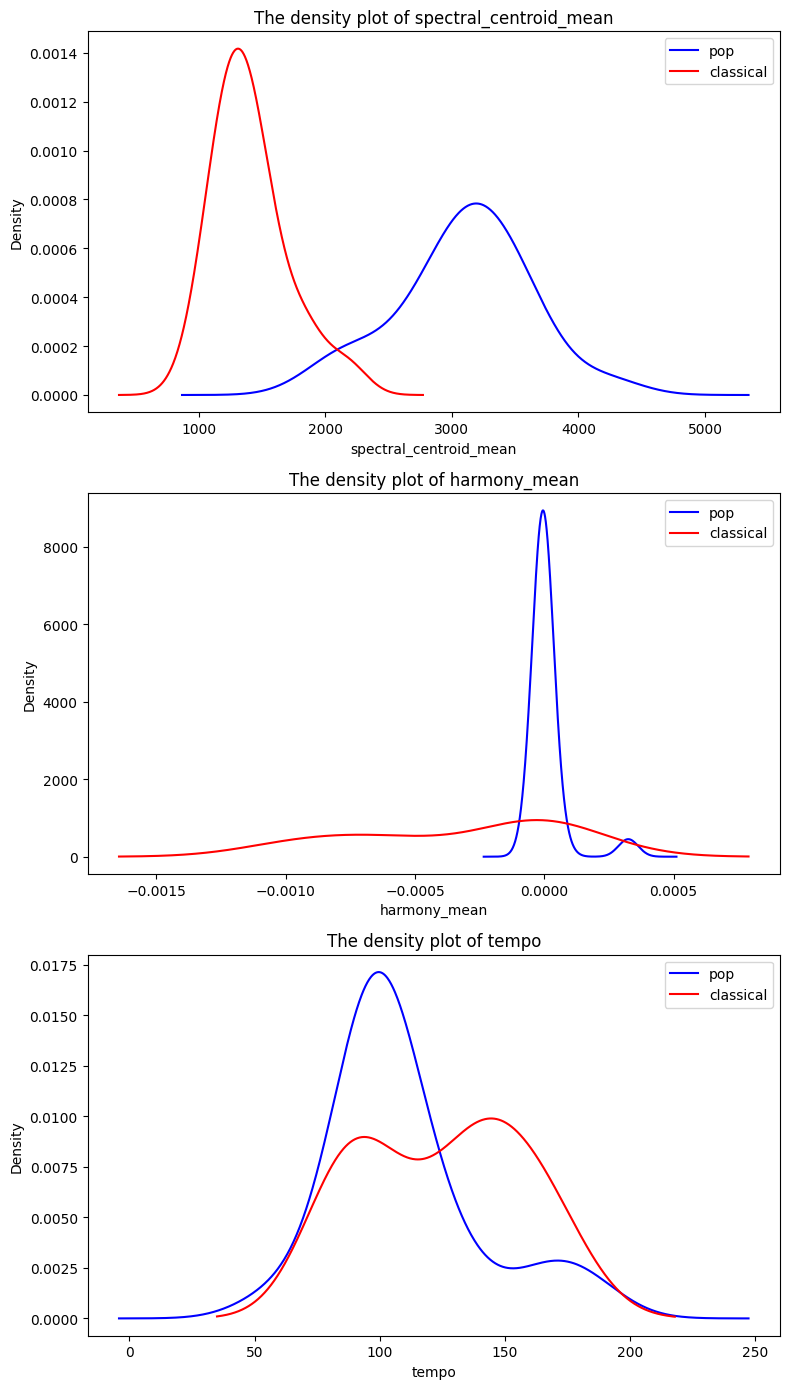

In [38]:
pop_data = test_data_df[test_data_df['label'] == 'pop']
classical_data = test_data_df[test_data_df['label'] == 'classical']

custom_lines = [Line2D([0], [0], color="blue"),
                Line2D([0], [0], color="red")]

plt.figure(figsize=(8,14))

plt.subplot(311).legend(custom_lines, ['pop', 'classical'])
pop_data.spectral_centroid_mean.plot.density(color='blue')
classical_data.spectral_centroid_mean.plot.density(color='red')
plt.xlabel("spectral_centroid_mean")
plt.title("The density plot of spectral_centroid_mean")
# plt.legend(custom_lines, ['pop', 'classical'])

plt.subplot(312).legend(custom_lines, ['pop', 'classical'])
pop_data.harmony_mean.plot.density(color='blue')
classical_data.harmony_mean.plot.density(color='red')
plt.xlabel("harmony_mean")
plt.title("The density plot of harmony_mean")
# plt.legend(custom_lines, ['pop', 'classical'])

plt.subplot(313).legend(custom_lines, ['pop', 'classical'])
pop_data.tempo.plot.density(color='blue')
classical_data.tempo.plot.density(color='red')
plt.xlabel("tempo")
plt.title("The density plot of tempo")

plt.tight_layout()

<Axes: xlabel='harmony_mean', ylabel='Density'>

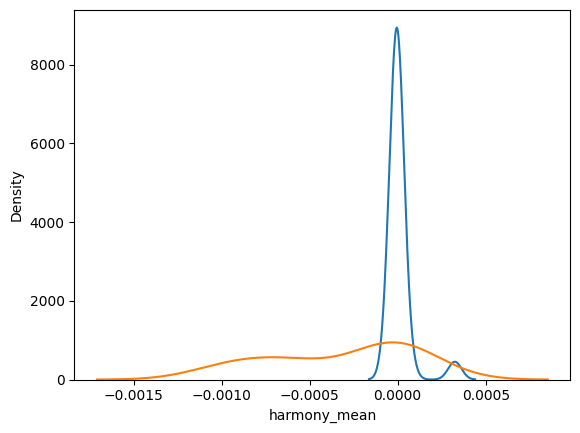

In [33]:
sns.kdeplot(pop_data['harmony_mean'])
sns.kdeplot(classical_data['harmony_mean'])

I may choose spectral_centroid_mean to be the attribute X. The reason to choose one of the three attributes is that we want one attribute to best distinguish two labels (pop and classical). That is to find the graph which has the minimum area of overlaps between the blue and red curves. 

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.